In [3]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Sample implementation of FFNN 

In [35]:
import random
import numpy as np

class DeepFFNN(object):
    """
    Author: Hanbaek Lyu
    Genearal Deep Feedforward Neural Network implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    
    pattern i = [np.array (input), np.array (output)]
    
    TODO: Currently uses square loss. Should be easy to implement other loss functions. 
    """
    def __init__(self, 
                 hidden_layer_sizes,  # input and output layer sizes read off from training data
                 training_data,  # list of patterns [np.array (input), np.array (output)]
                 activation_list=None): # desired list of activation functions in each layer. 
       
        # initialize training data and layer info
        self.training_data = training_data
        self.activation_list = activation_list
        self.list_layer_sizes = [len(self.training_data[0][0]) + 1] + hidden_layer_sizes + [len(self.training_data[0][1])]        
        # add hidden unit in the input layer. No hidden units for the hidden layers. 
        self.n_layers = len(self.list_layer_sizes)-1
        
        self.initialize()
        
    def initialize(self):
        
        # list of activation functions
        if self.activation_list is None:
            activation_list = ['tanh' for i in np.arange(len(self.list_layer_sizes))]
            activation_list[0] = 'identity'  # dummy activation for the input layer
            activation_list[-1] = 'sigmoid'
            self.activation_list = activation_list

        # default activation of nodes
        node_states = []
        for i in np.arange(len(self.list_layer_sizes)):
            node_states.append(np.zeros(shape=[self.list_layer_sizes[i], ]))
        self.node_states = node_states
#         print('node_states',node_states) # initially 0
        # initial weight matrices 
        # use scheme from 'efficient backprop to initialize weights'
        weight_matrices = []
        for i in np.arange(self.n_layers):
            weight_range = 1/(self.list_layer_sizes[i]**(0.5))
            U = np.random.normal(loc = 0, scale = weight_range, size = (self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            weight_matrices.append(U)
            print('weight_matrix.shape', U.shape)
        self.weight_matrices = weight_matrices
           
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        prev_grad_list = []
        for i in np.arange(self.n_layers):
            V = np.zeros((self.list_layer_sizes[i], self.list_layer_sizes[i+1]))
            prev_grad_list.append(V)
        self.prev_grad_list = prev_grad_list

    def forwardPropagate(self, inputs):
#         print('input shape',np.array(inputs).shape) # 1 28 28
#         print('inputs0',inputs[0]) # image
        # Forward propagate the input using the current weights and update node states
#         print('state0',self.node_states[0])
#         print('state0-1',self.node_states[0][:-1])
        self.node_states[0][:-1] = inputs # avoid last coordinate for hidden unit 
        for i in np.arange(self.n_layers):    
            X_new = self.node_states[i].T @ self.weight_matrices[i]
            X_new = activation(X_new, type=self.activation_list[i+1])
            self.node_states[i+1] = X_new
        
        return self.node_states[-1]

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """
    
        error_list = self.node_states.copy()
        # error at the output layer to be backpropagated 
        error = -(np.asarray(targets) - np.asarray(self.node_states[-1]))
        for L in range(self.n_layers, 0, -1): # layer index to be backpropagated 
            # print('L', L)
            if L < self.n_layers: # Not backpropagating from the output layer
                error = self.weight_matrices[L] @ error_list[L+1].reshape(-1,1)
                error = error[:,0] 
            error_list[L] = delta_activation(self.node_states[L], type=self.activation_list[L]) * error
            
        # Compute the gradients
        grad_list = self.weight_matrices.copy()
        for i in np.arange(self.n_layers):
            grad_list[i] = self.node_states[i].reshape(-1,1) @ error_list[i+1].reshape(1,-1) 
        
        return grad_list


    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01, verbose=True):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.forwardPropagate(inputs)
                grad_list = self.backPropagate(targets)
                
                for L in np.arange(self.n_layers):
                    # update the L th weight matrix connecting L th and (L+1)st layers 
                    grad = grad_list[L]
                    prev_grad = self.prev_grad_list[L]
                    self.weight_matrices[L] -= self.learning_rate * grad + self.momentum * prev_grad
                    self.prev_grad_list[L] = grad # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.node_states[-1])**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if (i % 5 == 0) and verbose:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1  
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
        print('X.shape', X.shape)
    
        for i in np.arange(self.n_layers):    
            x = x.T @ self.weight_matrices[i]
            x = activation(x.T, type=self.activation_list[i+1])
            
        print('y_hat.shape', x.shape)
        return x
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y


### Helper functions

def loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    if type == 'cross_entropy':
        return cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return (1/2) * (y_hat - y).T @ (y_hat - y)
    elif type == 'softmax-cross-entropy':
        return cross_entropy(y=y, y_hat=softmax(y_hat))
   

def delta_loss_function(y, y_hat, type='cross-entropy'):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    # return delta_cross_entropy(y=y, y_hat=y_hat/np.sum(y_hat))
    
    if type == 'cross-entropy':
        return delta_cross_entropy(y=y, y_hat=y_hat)
    elif type == 'square':
        return y_hat - y
    elif type == 'softmax-cross-entropy':
        return softmax(y_hat) - y

        
def activation(x, type='sigmoid'):
    if type == 'sigmoid':
        return 1/(1+np.exp(-x))
    elif type == 'ReLU':
        return np.maximum(0,x)
    elif type == 'tanh':
        return tanh(x)
    elif type == 'identity':
        return x
    
def delta_activation(y, type='sigmoid'):
    # derivate of activation function
    if type == 'sigmoid':
        return y*(1-y)
    elif type == 'ReLU':
        return int((y>0))
    elif type == 'tanh':
        return 1-y**2
    elif type == 'identity':
        return 1
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)


def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

def cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    return -(y.T @ np.log(y_hat))[0][0]

def delta_cross_entropy(y, y_hat):
    """
    y_hat = column array of predictive PMF 
    y = column array of one-hot encoding of true class label
    """
    y_hat /= np.max(y_hat)
    z = y.copy()
    for i in np.arange(y.shape[0]):
        a = y.argmax(axis=0)[0]
        z[i,0] = -1/y_hat[a, 0]
    return z

## Classifying MNIST images using FFNN

In [5]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [6]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [7]:
def sample_multiclass_MNIST(list_digits=['0','1', '2'], full_MNIST=None):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X.iloc[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01.iloc[i,:])
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(X01.iloc[i,:])
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test


In [8]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix  ===> \n', mcm)
            
    return results_dict

In [9]:
def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels [samples x labels]
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                # print('!!!', np.where(P_pred[i,:]==np.max(P_pred[i,:])))
                y_pred.append(j)
            
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    results_dict.update({'confusion_mx':confusion_mx})
    results_dict.update({'Accuracy':np.trace(confusion_mx)/np.sum(np.sum(confusion_mx))})
    print('!!! confusion_mx', confusion_mx)
    print('!!! Accuracy', results_dict.get('Accuracy'))
    
    
    return results_dict

In [32]:
# Simple MNIST binary classification experiments 

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=['0','1'], full_MNIST=[X,y])
3
# data subsampling 
train_size = 100

idx = np.random.choice(np.arange(len(y_train)), train_size)
X_train0 = X_train[idx, :]/np.max(X_train)
y_train0 = y_train[idx, :]

# preprocessing 
out = []
# populate the tuple list with the data
for i in range(X_train0.shape[0]):
    item = list((X_train0[i,:], y_train0[i,:])) # don't mind this variable name
    out.append(item)

# FFNN training
NN = DeepFFNN(hidden_layer_sizes=[10], training_data = out)
NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

#NN = MLP_NeuralNetwork_fast(hidden=M, training_data = out)
#NN.train(iterations=100, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)

# FFNN prediction

X_test /= np.max(X_test)
out_test = []
for i in range(X_test.shape[0]):
    out_test.append(X_test[i,:].tolist())

y_hat = NN.predict(out_test).T
y_test_label = np.asarray(onehot2list(y_test))
P_pred = np.asarray([p[1] for p in y_hat])

compute_accuracy_metrics(Y_test=y_test_label, P_pred=P_pred, use_opt_threshold=False, verbose=True)


100%|██████████████████████████████████████████████████████████████████████████| 14780/14780 [00:01<00:00, 8183.18it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 2)
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape 

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
iteration 70, error 0.02053
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input shape (784,)
inputs0 0.0
input sh

X.shape (784, 2946)
y_hat.shape (2, 2946)
AUC ===> 1.000
Opt_threshold ===> 0.722
Accuracy ===> 0.998
Sensitivity ===> 0.997
Specificity ===> 0.998
Precision ===> 0.997
Fall_out ===> 0.003
Miss_rate ===> 0.002
Confusion matrix  ===> 
 [[1371    4]
 [   3 1568]]


{'Y_test': array([1, 1, 0, ..., 1, 0, 0]),
 'Y_pred': array([1., 1., 0., ..., 1., 0., 0.]),
 'AUC': 0.9997601990625543,
 'Opt_threshold': 0.7219157185771415,
 'Accuracy': 0.9976238968092329,
 'Sensitivity': 0.9970909090909091,
 'Specificity': 0.9980903882877148,
 'Precision': 0.9974554707379135,
 'Fall_out': 0.002909090909090909,
 'Miss_rate': 0.0019096117122851686,
 'Confusion_mx': array([[1371,    4],
        [   3, 1568]], dtype=int64)}

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:10<00:00, 6637.58it/s]


weight_matrix.shape (785, 2)
weight_matrix.shape (2, 10)
iteration 0, error 10.29389
iteration 5, error 5.42376
iteration 10, error 4.97908
iteration 15, error 4.77515
iteration 20, error 4.65395
iteration 25, error 4.57215
iteration 30, error 4.51231
iteration 35, error 4.46628
iteration 40, error 4.42962
iteration 45, error 4.39959
iteration 50, error 4.37435
iteration 55, error 4.35284
iteration 60, error 4.33420
iteration 65, error 4.31786
iteration 70, error 4.30337
iteration 75, error 4.29046
iteration 80, error 4.27884
iteration 85, error 4.26829
iteration 90, error 4.25868
iteration 95, error 4.24986
iteration 100, error 4.24176
iteration 105, error 4.23428
iteration 110, error 4.22735
iteration 115, error 4.22089
iteration 120, error 4.21486
iteration 125, error 4.20922
iteration 130, error 4.20393
iteration 135, error 4.19897
iteration 140, error 4.19428
iteration 145, error 4.18986
iteration 150, error 4.18568
iteration 155, error 4.18172
iteration 160, error 4.17795
iterati

iteration 335, error 0.60597
iteration 340, error 0.60150
iteration 345, error 0.59714
iteration 350, error 0.59287
iteration 355, error 0.58869
iteration 360, error 0.58459
iteration 365, error 0.58059
iteration 370, error 0.57666
iteration 375, error 0.57282
iteration 380, error 0.56905
iteration 385, error 0.56536
iteration 390, error 0.56173
iteration 395, error 0.55818

X.shape (784, 10)
y_hat.shape (10, 10)
X.shape (784, 14036)
y_hat.shape (10, 14036)
!!! confusion_mx [[1 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 2]]
!!! Accuracy 1.0
!!! confusion_mx [[ 843   18  499    0    4    0    0    1    0    0]
 [   0 1501   70    0    0    0    0    2    0    5]
 [ 140  567  634    0    2    0    0   14    0    0]
 [ 103  842  469    0    4    0    0    4    0    9]
 [ 375  300  108    0  312    0    0   25    0  270]
 [ 149  206  684    0   45    0    0    4    0  153]
 [ 236   86 1097    0    1    0    0    0    0    3]
 [ 223  267    7    0    

iteration 120, error 22.29421
iteration 125, error 22.29360
iteration 130, error 22.29306
iteration 135, error 22.29254
iteration 140, error 22.29204
iteration 145, error 22.29160
iteration 150, error 22.29118
iteration 155, error 22.29080
iteration 160, error 22.29042
iteration 165, error 22.29006
iteration 170, error 22.28974
iteration 175, error 22.28943
iteration 180, error 22.28913
iteration 185, error 22.28885
iteration 190, error 22.28859
iteration 195, error 22.28833
iteration 200, error 22.28808
iteration 205, error 22.28785
iteration 210, error 22.28763
iteration 215, error 22.28742
iteration 220, error 22.28722
iteration 225, error 22.28703
iteration 230, error 22.28683
iteration 235, error 22.28666
iteration 240, error 22.28648
iteration 245, error 22.28632
iteration 250, error 22.28616
iteration 255, error 22.28601
iteration 260, error 22.28585
iteration 265, error 22.28571
iteration 270, error 22.28557
iteration 275, error 22.28544
iteration 280, error 22.28530
iteration 

iteration 375, error 1.66412
iteration 380, error 1.65839
iteration 385, error 1.65279
iteration 390, error 1.64731
iteration 395, error 1.64195

X.shape (784, 50)
y_hat.shape (10, 50)
X.shape (784, 14036)
y_hat.shape (10, 14036)
!!! confusion_mx [[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 7 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 0 0 0 0 5]]
!!! Accuracy 0.96
!!! confusion_mx [[1217    7   28    0   20    4   34   28   23    4]
 [   1 1519   17    0    1    0   23    6   11    0]
 [  27  130  813    0  183    0   40   32  126    6]
 [  97  107  915    0   38   31   55   37  128   23]
 [   1   53   49    0 1136    1   17   11   11  111]
 [ 217   63  162    0   68  267  193   23  126  122]
 [  33   55  126    0   46    0 1150    3    4    6]
 [  47   61   31    0   72    8   13 1023   59  185]
 [  14  245  345    0   45   12   60   23  553  113]
 [  18   3

iteration 85, error 44.46109
iteration 90, error 44.46016
iteration 95, error 44.45939
iteration 100, error 44.45874
iteration 105, error 44.45810
iteration 110, error 44.45752
iteration 115, error 44.45687
iteration 120, error 44.45645
iteration 125, error 44.45597
iteration 130, error 44.45551
iteration 135, error 44.45503
iteration 140, error 44.45467
iteration 145, error 44.45428
iteration 150, error 44.45400
iteration 155, error 44.45363
iteration 160, error 44.45335
iteration 165, error 44.45307
iteration 170, error 44.45280
iteration 175, error 44.45250
iteration 180, error 44.45221
iteration 185, error 44.45197
iteration 190, error 44.45176
iteration 195, error 44.45152
iteration 200, error 44.45131
iteration 205, error 44.45108
iteration 210, error 44.45088
iteration 215, error 44.45070
iteration 220, error 44.45051
iteration 225, error 44.45032
iteration 230, error 44.45016
iteration 235, error 44.44997
iteration 240, error 44.44983
iteration 245, error 44.44966
iteration 250

iteration 310, error 1.84505
iteration 315, error 1.82782
iteration 320, error 1.81105
iteration 325, error 1.79476
iteration 330, error 1.77884
iteration 335, error 1.76348
iteration 340, error 1.74850
iteration 345, error 1.73389
iteration 350, error 1.71965
iteration 355, error 1.70577
iteration 360, error 1.69229
iteration 365, error 1.67913
iteration 370, error 1.66632
iteration 375, error 1.65387
iteration 380, error 1.64168
iteration 385, error 1.62981
iteration 390, error 1.61826
iteration 395, error 1.60699

X.shape (784, 100)
y_hat.shape (10, 100)
X.shape (784, 14036)
y_hat.shape (10, 14036)
!!! confusion_mx [[ 7  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0  0  0  0  6]]
!!! Accuracy 0.99
!!! confusion_mx [[1013  

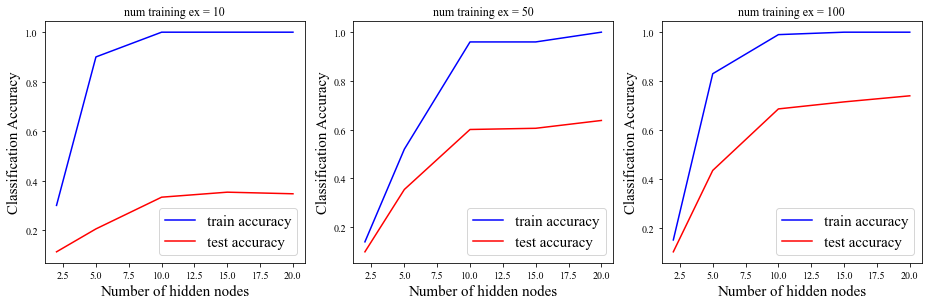

In [27]:
# compute comparative multiclass classification metrics on test data

M_list = [2, 5, 10, 15, 20]
# list_digits=['0','1','2','3','4']
list_digits= [str(l) for l in list(np.arange(0,10))]

# Data preprocessing

X_train, X_test, y_train, y_test = sample_multiclass_MNIST(list_digits=list_digits, full_MNIST=[X,y])

## Train
train_size_list = [10, 50, 100]

# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    idx = np.random.choice(np.arange(len(y_train)), train_size)
    X_train0 = X_train[idx, :]/np.max(X_train)
    y_train0 = y_train[idx, :]

    out = []
    out_train = []
    # populate the tuple list with the data
    for i in range(X_train0.shape[0]):
        item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) # don't mind this variable name
        out.append(item)
        out_train.append(X_train0[i,:].tolist())

    X_test /= np.max(X_test)
    out_test = []
    for i in range(X_test.shape[0]):
        out_test.append(X_test[i,:].tolist())

    for M in M_list:

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[M], training_data = out)
        NN.train(iterations=400, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        print()
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(M_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(M_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Number of hidden nodes', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_ex1.pdf')

In [12]:
import random
import numpy as np

class MLP(object):
    """
    Author: Hanbaek Lyu
    Multilayer Perceptron (2-layer Feedforward Neural Network) implementation 
    Input data type: training_data = [pattern1, pattern2, ..., pattern n]
    Activation: tanh for hidden layer and sigmoid for output layer 
    This 2-layer version should be easier to see what's going on than the deep FFNN code. 
    
    pattern i = [np.array (input), np.array (output)]
    
    """
    def __init__(self, 
                 hidden,
                 training_data):
       
        # initialize training data
        self.training_data = training_data
        
        # initialize layer sizes
        self.input = len(training_data[0][0]) + 1 # add 1 for bias node
        self.hidden = hidden
        self.output = len(training_data[0][1])

        # set up array of 1s for activations (node states)
        self.ai = np.ones(self.input)
        self.ah = np.ones(self.hidden)
        self.ao = np.ones(self.output)

        # create randomized weights
        # use scheme from 'efficient backprop to initialize weights'
        input_range = 1.0 / self.input ** (1/2)
        output_range = 1.0 / self.hidden ** (1/2)
        self.wi = np.random.normal(loc = 0, scale = input_range, size = (self.input, self.hidden))
        self.wo = np.random.normal(loc = 0, scale = output_range, size = (self.hidden, self.output))
        
        # create arrays of 0's to store previous gradients for momentum term in SGD update 
        self.ci = np.zeros((self.input, self.hidden))
        self.co = np.zeros((self.hidden, self.output))

    def feedForward(self, inputs):    
        # input activations
        self.ai[:-1] = inputs # -1 is to avoid the bias 
        # hidden activations
        self.ah = tanh(self.ai.T @ self.wi).T # hidden states 
        # output activations
        self.ao = sigmoid(self.ah.T @ self.wo).T # output states 
        
        return self.ao

    def backPropagate(self, targets):
        """
        Backpropagate errors from the output to the input layer 
        Return gradients for the weight matrices
        """

        # calculate error terms for output
        error = -(np.asarray(targets) - np.asarray(self.ao))
        output_deltas = dsigmoid(np.asarray(self.ao)) * error
        output_deltas.tolist()
        
        # calculate error terms for hidden
        error = self.wo @ output_deltas.reshape(-1,1)
        hidden_deltas = dtanh(self.ah.reshape(-1,1)) * error
        hidden_deltas = hidden_deltas[:,0]
            
        # compute gradients 
        grad1 = self.ah.reshape(-1,1) @ output_deltas.reshape(1,-1) 
        grad0 = self.ai.reshape(-1,1) @ hidden_deltas.reshape(1,-1) 
        
        return grad0, grad1
    
    def backPropagate(self,targets,):
        return
    
    def test(self, patterns):
        """
        Currently this will print out the targets next to the predictions.
        Not useful for actual ML, just for visual inspection.
        """
        for p in patterns:
            print(p[1], '->', self.feedForward(p[0]))

    def train(self, iterations=100, learning_rate=0.5, momentum=0.5, rate_decay=0.01):
        # N: learning rate
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.rate_decay = rate_decay
        error = 10
        i=0
        while (i<iterations) and (error>0.001):
            error = 0.0
            random.shuffle(self.training_data)
            for p in self.training_data:
                inputs = p[0]
                targets = p[1]
                self.feedForward(inputs)
                grad0, grad1 =self.backPropagate(targets)
            
                # update the weights connecting hidden to output
                self.wo -= self.learning_rate * grad1 + self.momentum * self.co
                self.co = grad1 # store current gradient 

                # update the weights connecting input to hidden
                self.wi -= self.learning_rate * grad0 + self.momentum * self.ci
                self.ci = grad0 # store current gradient 
        
                error += (0.5) * np.linalg.norm(np.asarray(targets) - self.ao)**2
            
            with open('error.txt', 'a') as errorfile:
                errorfile.write(str(error) + '\n')
                errorfile.close()
                
            if i % 5 == 0:
                print('iteration %i, error %-.5f' % (i, error))
            # learning rate decay
            self.learning_rate = 1/(np.log(i+2) * (i+50)**(0.5))
            # self.learning_rate = self.learning_rate * (self.learning_rate / (self.learning_rate + (self.learning_rate * self.rate_decay)))
            
            i += 1    
        
    
    def predict(self, X, normalize = False):
        X = np.asarray(X).T
        x = np.vstack((np.asarray(X), np.ones(X.shape[1]))) # add 1 for hidden units in the input layer
       
        W0 = self.wi
        W1 = self.wo 
        z = tanh(x.T @ W0).T # hidden states 
        y_hat = sigmoid((z.T @ W1).T) # output states
        
        if normalize:
            sum_of_cols = y_hat.sum(axis=0)
            y_hat /= sum_of_cols[np.newaxis,:]
        
        return y_hat
    
### Helper functions     
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def dsigmoid(y):
    return y * (1.0 - y)

# using tanh over logistic sigmoid is recommended   

def tanh(x):
    return (1-np.exp(-2*x))/(1+np.exp(-2*x))
    # return np.tanh(x)
    
# derivative for tanh sigmoid
def dtanh(y):
    return 1 - y*y

# HW 7 3

In [13]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

In [14]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X.iloc[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01.iloc[i,:].values.reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 4426.80it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 5)
iteration 0, error 63.51575
iteration 5, error 7.92510
iteration 10, error 5.24044
iteration 15, error 4.43830
iteration 20, error 3.87312
iteration 25, error 3.47747
iteration 30, error 3.21466
iteration 35, error 3.03532
iteration 40, error 2.89967
iteration 45, error 2.79206
iteration 50, error 2.70183
iteration 55, error 2.62501
iteration 60, error 2.55657
iteration 65, error 2.49519
iteration 70, error 2.43909
iteration 75, error 2.38669
iteration 80, error 2.33745
iteration 85, error 2.29051
iteration 90, error 2.24696
iteration 95, error 2.20769
iteration 100, error 2.17251
iteration 105, error 2.14074
iteration 110, error 2.11128
iteration 115, error 2.08361
iteration 120, error 2.05765
iteration 125, error 2.03281
iteration 130, error 2.00889
iteration 135, error 1.98578
iteration 140, error 1.96349
iteration 145, error 1.94154
iteration 150, error 1.92008
iteration 155, error 1.89861
iteration 160, error 1.87753
iterat

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:07<00:00, 4930.21it/s]


weight_matrix.shape (1226, 10)
weight_matrix.shape (10, 5)
iteration 0, error 120.39774
iteration 5, error 45.49587
iteration 10, error 24.76597
iteration 15, error 18.30151
iteration 20, error 15.49088
iteration 25, error 13.65460
iteration 30, error 12.29568
iteration 35, error 11.55108
iteration 40, error 10.99757
iteration 45, error 10.45371
iteration 50, error 10.02471
iteration 55, error 9.72111
iteration 60, error 9.48355
iteration 65, error 9.28918
iteration 70, error 9.11245
iteration 75, error 8.96367
iteration 80, error 8.82351
iteration 85, error 8.69514
iteration 90, error 8.57804
iteration 95, error 8.47090
iteration 100, error 8.37299
iteration 105, error 8.28244
iteration 110, error 8.19739
iteration 115, error 8.11711
iteration 120, error 8.04152
iteration 125, error 7.96775
iteration 130, error 7.89475
iteration 135, error 7.80587
iteration 140, error 7.23470
iteration 145, error 6.07604
iteration 150, error 5.78969
iteration 155, error 5.34691
iteration 160, error 5.

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:09<00:00, 3759.69it/s]


weight_matrix.shape (1682, 10)
weight_matrix.shape (10, 5)
iteration 0, error 124.90117
iteration 5, error 50.91316
iteration 10, error 29.36295
iteration 15, error 20.92660
iteration 20, error 16.72716
iteration 25, error 13.84840
iteration 30, error 12.06205
iteration 35, error 10.59747
iteration 40, error 9.31597
iteration 45, error 8.39060
iteration 50, error 7.68470
iteration 55, error 7.20292
iteration 60, error 6.77658
iteration 65, error 6.38603
iteration 70, error 6.08904
iteration 75, error 5.83370
iteration 80, error 5.60304
iteration 85, error 5.38611
iteration 90, error 5.15753
iteration 95, error 4.78825
iteration 100, error 4.54211
iteration 105, error 4.33897
iteration 110, error 4.14981
iteration 115, error 3.97792
iteration 120, error 3.82595
iteration 125, error 3.69729
iteration 130, error 3.56255
iteration 135, error 3.31704
iteration 140, error 3.01248
iteration 145, error 2.90001
iteration 150, error 2.80510
iteration 155, error 2.72226
iteration 160, error 2.644

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:09<00:00, 3663.38it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 5)
iteration 0, error 125.84489
iteration 5, error 71.07458
iteration 10, error 38.62237
iteration 15, error 24.79215
iteration 20, error 18.64420
iteration 25, error 14.27627
iteration 30, error 11.80962
iteration 35, error 10.31535
iteration 40, error 9.11681
iteration 45, error 7.97101
iteration 50, error 7.11938
iteration 55, error 6.49160
iteration 60, error 5.95620
iteration 65, error 5.53006
iteration 70, error 5.18752
iteration 75, error 4.89456
iteration 80, error 4.62927
iteration 85, error 4.34894
iteration 90, error 4.12205
iteration 95, error 3.93881
iteration 100, error 3.76510
iteration 105, error 3.59114
iteration 110, error 3.41548
iteration 115, error 3.25295
iteration 120, error 3.11661
iteration 125, error 2.99512
iteration 130, error 2.87926
iteration 135, error 2.77466
iteration 140, error 2.68066
iteration 145, error 2.59547
iteration 150, error 2.52052
iteration 155, error 2.45586
iteration 160, error 2.398

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 4433.74it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 5)
iteration 0, error 90.18256
iteration 5, error 11.54250
iteration 10, error 9.86422
iteration 15, error 6.95437
iteration 20, error 5.64392
iteration 25, error 5.13003
iteration 30, error 4.83250
iteration 35, error 4.60752
iteration 40, error 4.38577
iteration 45, error 4.03203
iteration 50, error 3.89026
iteration 55, error 3.78045
iteration 60, error 3.68723
iteration 65, error 3.60569
iteration 70, error 3.53332
iteration 75, error 3.47018
iteration 80, error 3.41393
iteration 85, error 3.36341
iteration 90, error 3.31781
iteration 95, error 3.27627
iteration 100, error 3.23814
iteration 105, error 3.20277
iteration 110, error 3.16975
iteration 115, error 3.13873
iteration 120, error 3.10937
iteration 125, error 3.08145
iteration 130, error 3.05484
iteration 135, error 3.02920
iteration 140, error 3.00472
iteration 145, error 2.98094
iteration 150, error 2.95821
iteration 155, error 2.93605
iteration 160, error 2.91451
itera

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 3984.64it/s]


weight_matrix.shape (1226, 10)
weight_matrix.shape (10, 5)
iteration 0, error 179.69624
iteration 5, error 54.39006
iteration 10, error 33.30217
iteration 15, error 24.34385
iteration 20, error 20.05506
iteration 25, error 17.43365
iteration 30, error 15.22544
iteration 35, error 12.77734
iteration 40, error 11.39467
iteration 45, error 10.55293
iteration 50, error 9.83480
iteration 55, error 9.24501
iteration 60, error 8.78639
iteration 65, error 8.34864
iteration 70, error 7.71111
iteration 75, error 7.08227
iteration 80, error 6.53312
iteration 85, error 6.10132
iteration 90, error 5.83374
iteration 95, error 5.57908
iteration 100, error 5.16945
iteration 105, error 4.84112
iteration 110, error 4.60167
iteration 115, error 4.46282
iteration 120, error 4.34880
iteration 125, error 4.24960
iteration 130, error 4.15941
iteration 135, error 4.07944
iteration 140, error 4.00495
iteration 145, error 3.93631
iteration 150, error 3.87165
iteration 155, error 3.81210
iteration 160, error 3.7

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 4308.79it/s]


weight_matrix.shape (1682, 10)
weight_matrix.shape (10, 5)
iteration 0, error 203.86108
iteration 5, error 112.04362
iteration 10, error 82.22215
iteration 15, error 62.76513
iteration 20, error 48.36103
iteration 25, error 38.00136
iteration 30, error 32.16828
iteration 35, error 28.99587
iteration 40, error 26.99157
iteration 45, error 25.35918
iteration 50, error 23.87303
iteration 55, error 22.28934
iteration 60, error 21.13393
iteration 65, error 20.09429
iteration 70, error 19.34314
iteration 75, error 18.88837
iteration 80, error 18.37329
iteration 85, error 17.66669
iteration 90, error 17.31131
iteration 95, error 16.95016
iteration 100, error 16.67084
iteration 105, error 16.44700
iteration 110, error 16.23630
iteration 115, error 15.67759
iteration 120, error 15.33346
iteration 125, error 15.14581
iteration 130, error 14.95934
iteration 135, error 14.73173
iteration 140, error 14.22995
iteration 145, error 13.72904
iteration 150, error 13.53498
iteration 155, error 13.41853
i

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 4097.79it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 5)
iteration 0, error 202.69870
iteration 5, error 112.87999
iteration 10, error 76.00333
iteration 15, error 56.06147
iteration 20, error 43.23572
iteration 25, error 33.89454
iteration 30, error 27.60105
iteration 35, error 23.87732
iteration 40, error 21.21731
iteration 45, error 18.10884
iteration 50, error 16.19959
iteration 55, error 14.79081
iteration 60, error 13.67779
iteration 65, error 12.97068
iteration 70, error 12.44001
iteration 75, error 11.94426
iteration 80, error 11.29225
iteration 85, error 10.65549
iteration 90, error 10.22785
iteration 95, error 9.95576
iteration 100, error 9.71805
iteration 105, error 9.49969
iteration 110, error 9.31977
iteration 115, error 9.14458
iteration 120, error 8.99468
iteration 125, error 8.85976
iteration 130, error 8.74333
iteration 135, error 8.62258
iteration 140, error 8.51824
iteration 145, error 8.41266
iteration 150, error 8.31437
iteration 155, error 8.20880
iteration 160,

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:08<00:00, 4103.51it/s]


weight_matrix.shape (785, 10)
weight_matrix.shape (10, 5)
iteration 0, error 145.90593
iteration 5, error 17.55296
iteration 10, error 12.97523
iteration 15, error 10.53371
iteration 20, error 8.54936
iteration 25, error 7.97869
iteration 30, error 7.44465
iteration 35, error 7.04728
iteration 40, error 6.75392
iteration 45, error 6.56320
iteration 50, error 6.05376
iteration 55, error 5.83613
iteration 60, error 5.72074
iteration 65, error 5.61884
iteration 70, error 5.51524
iteration 75, error 5.41906
iteration 80, error 5.34834
iteration 85, error 5.29093
iteration 90, error 5.24154
iteration 95, error 5.19731
iteration 100, error 5.15622
iteration 105, error 5.11941
iteration 110, error 5.08540
iteration 115, error 5.05306
iteration 120, error 5.02287
iteration 125, error 4.99418
iteration 130, error 4.96704
iteration 135, error 4.94131
iteration 140, error 4.91637
iteration 145, error 4.89233
iteration 150, error 4.86919
iteration 155, error 4.84712
iteration 160, error 4.82581
it

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:10<00:00, 3438.25it/s]


weight_matrix.shape (1226, 10)
weight_matrix.shape (10, 5)
iteration 0, error 343.61259
iteration 5, error 105.95611
iteration 10, error 69.76813
iteration 15, error 55.15568
iteration 20, error 48.16615
iteration 25, error 43.23621
iteration 30, error 40.70602
iteration 35, error 38.59588
iteration 40, error 37.14239
iteration 45, error 35.79463
iteration 50, error 33.88040
iteration 55, error 32.24927
iteration 60, error 30.96942
iteration 65, error 30.28034
iteration 70, error 29.70757
iteration 75, error 29.03610
iteration 80, error 27.64287
iteration 85, error 27.00041
iteration 90, error 26.16752
iteration 95, error 25.06679
iteration 100, error 24.15388
iteration 105, error 23.67754
iteration 110, error 23.17307
iteration 115, error 22.73591
iteration 120, error 22.45034
iteration 125, error 22.12514
iteration 130, error 21.85132
iteration 135, error 21.61610
iteration 140, error 21.06903
iteration 145, error 20.60452
iteration 150, error 20.24936
iteration 155, error 20.05516
i

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:07<00:00, 4997.77it/s]


weight_matrix.shape (1682, 10)
weight_matrix.shape (10, 5)
iteration 0, error 397.49774
iteration 5, error 159.49079
iteration 10, error 96.39330
iteration 15, error 68.21144
iteration 20, error 54.95713
iteration 25, error 45.83344
iteration 30, error 41.74566
iteration 35, error 39.12381
iteration 40, error 36.01598
iteration 45, error 33.52963
iteration 50, error 31.87085
iteration 55, error 30.22451
iteration 60, error 29.13345
iteration 65, error 27.75284
iteration 70, error 26.53251
iteration 75, error 25.49496
iteration 80, error 24.27969
iteration 85, error 23.10780
iteration 90, error 22.43834
iteration 95, error 21.89557
iteration 100, error 21.18649
iteration 105, error 19.96611
iteration 110, error 19.53758
iteration 115, error 19.19387
iteration 120, error 18.85700
iteration 125, error 18.58752
iteration 130, error 18.35033
iteration 135, error 18.12134
iteration 140, error 17.90223
iteration 145, error 17.70665
iteration 150, error 17.52671
iteration 155, error 17.35830
i

100%|██████████████████████████████████████████████████████████████████████████| 35735/35735 [00:06<00:00, 5898.47it/s]


weight_matrix.shape (2305, 10)
weight_matrix.shape (10, 5)
iteration 0, error 405.46459
iteration 5, error 218.03595
iteration 10, error 158.98406
iteration 15, error 122.91567
iteration 20, error 100.45243
iteration 25, error 82.25156
iteration 30, error 68.34555
iteration 35, error 59.58751
iteration 40, error 52.59901
iteration 45, error 48.70987
iteration 50, error 45.76631
iteration 55, error 43.05780
iteration 60, error 40.55008
iteration 65, error 38.70910
iteration 70, error 37.54656
iteration 75, error 36.32826
iteration 80, error 35.29752
iteration 85, error 34.02548
iteration 90, error 33.21699
iteration 95, error 32.46431
iteration 100, error 31.67643
iteration 105, error 30.48685
iteration 110, error 29.08129
iteration 115, error 26.90195
iteration 120, error 26.26284
iteration 125, error 25.75714
iteration 130, error 25.20398
iteration 135, error 24.80265
iteration 140, error 24.45027
iteration 145, error 24.15332
iteration 150, error 23.74455
iteration 155, error 23.3766

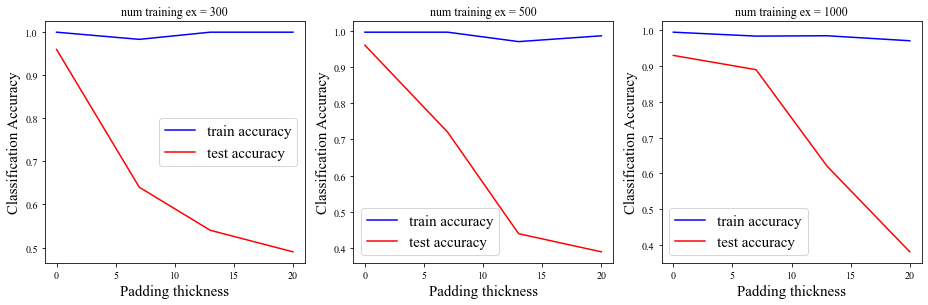

In [37]:
# compute comparative multiclass classification metrics on test data

padding_list = [0, 7, 13, 20]
list_digits=['0','1','2','3','4']

## Train
train_size_list = [300, 500, 1000]
# make plot
ncols = len(train_size_list)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        # Data preprocessing
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                           full_MNIST=[X,y], 
                                                                           padding_thickness=thickness)
            
        idx = np.random.choice(np.arange(len(y_train)), train_size)
        X_train0 = X_train[idx, :]/np.max(X_train)
        y_train0 = y_train[idx, :]

        
        
        idx = np.random.choice(np.arange(len(y_test)), 100)
        X_test0 = X_test[idx, :]/np.max(X_test)
        y_test0 = y_test[idx, :]

        out = []
        out_train = []
        # populate the tuple list with the data
        for i in range(X_train0.shape[0]):
            item = list((X_train0[i,:].tolist(), y_train0[i,:].tolist())) 
            
            out.append(item)
            out_train.append(X_train0[i,:].tolist())

        X_test /= np.max(X_test)
        out_test = []
        for i in range(X_test0.shape[0]):
            out_test.append((X_test0[i,:].tolist()))

        # FFNN training
        NN = DeepFFNN(hidden_layer_sizes=[10], training_data = out)
        NN.train(iterations=400, learning_rate = 0.5, momentum = 0, rate_decay = 0.01)
        
        # FFNN prediction
        y_hat_train = NN.predict(out_train, normalize=True)
        y_hat_test = NN.predict(out_test, normalize=True)

        y_train_label = np.asarray(onehot2list(y_train0))
        y_test_label = np.asarray(onehot2list(y_test))
        
        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=y_hat_train.T)
        results_test = multiclass_accuracy_metrics(Y_test=y_test0, P_pred=y_hat_test.T)

        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
    
    ## Plot
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)
            
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.savefig('MNIST_FFNN_accuracy_padding_ex2.pdf')